### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

### Set-up

For this expercise, we will utilize two files (listed below) from the 'Brazilian E-Commerce Public Dataset' originally posted on [Kaggle]( https://www.kaggle.com/olistbr/brazilian-ecommerce).

In [2]:
# Full path of the 'orders' dataset
orders_file = 'https://www.dropbox.com/s/ej64qorm1uvmjlp/olist_orders_dataset.csv?dl=1'

# Full path of the 'customer' dataset
cust_file = 'https://www.dropbox.com/s/t082qlggu4wxiq5/olist_customers_dataset.csv?dl=1'

# File output location
out = r"C:\Users\scheerja\Downloads"

### Read data

In [3]:
def read_olist_data(file1, file2):
    
    # Read the orders data
    orders = pd.read_csv(file1)

    print (f'{len(orders):,d} read from the orders file.')

    # Drop unnecessary columns
    drop_vars = ['order_approved_at', 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 'order_estimated_delivery_date']

    orders = orders.drop(drop_vars, axis=1)

    # Date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

    # Let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

    # Extract month from the order date
    orders['order_month'] = orders['order_purchase_timestamp'].dt.month

    # Read the file that contains the unique customer identifier
    cust = pd.read_csv(file2)

    print (f'{len(cust):,d} read from the customer file.')

    # Let's keep only the following two columns: customer_id, customer_unique_id
    cust = cust[['customer_id', 'customer_unique_id']]

    # Merge orders and cust dataframes
    orders = pd.merge(orders, cust, on='customer_id', how='inner')
    
    print (f'{len(orders):,d} records in the output  file.')
    
    return orders

orders = read_olist_data(orders_file, cust_file)

orders.head()

99,441 read from the orders file.
99,441 read from the customer file.
99,441 records in the output  file.


,order_id,customer_id,order_status,order_purchase_timestamp,order_purchase_date,order_month,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02,10,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-24,7,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08,8,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18,11,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13,2,72632f0f9dd73dfee390c9b22eb56dd6


## Binary Classification model

Let's build a model to predict whether a customer will make a purchase within the next month.

We will use *August 2018*, which is the most recent month, as the prediction window.

### Order recency

In [4]:
# Let's keep only those columns that we need (for this exercise)

keep_cols = ['customer_unique_id', 'order_id', 'order_purchase_timestamp']

orders = orders[keep_cols]

orders.head()

,customer_unique_id,order_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


For creating model attributes (features) we will have to restrict our data to the timeframe prior to the prediction window

In [11]:
print (len(orders))

# Select data prior to the prediction window
snapshot_date = date(2018, 7, 31)
attr_raw = orders[orders['order_purchase_timestamp'].dt.date <= snapshot_date]

len(attr_raw)

99441


92909

In [12]:
# Check to make sure that the max date is 31-JUL-2018
attr_raw.order_purchase_timestamp.max()


Timestamp('2018-07-31 23:54:20')

In [13]:
# Another way to make such filter is by using a "mask"

mask = orders['order_purchase_timestamp'].dt.date <= snapshot_date

attr_raw = orders[mask]

len(attr_raw)

92909

To calculate recency (days since the most recent order), we will have to extract the most recent date for each customer.

In [14]:
# Get the max date for each customer

cust_recency = attr_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

cust_recency.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [15]:
# Calculate recency

snapshot_date = date(2018, 7, 31)

delta = snapshot_date - cust_recency.order_purchase_timestamp.dt.date

In [19]:
# Get the number of days from the calculated deltas 

cust_recency['order_recency'] = delta.dt.days

cust_recency.head()

,customer_unique_id,order_recency
0,0000366f3b9a7992bf8c76cfdf3221e2,82
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85
2,0000f46a3911fa3c0805444483337064,508
3,0000f6ccb0745a6a4b88665a16c9f078,292
4,0004aac84e0df4da2b147fca70cf8255,259


In [17]:
# Drop the date (we don't need it any more for this exercise)

## -- INSERT CODE HERE -- ##
cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

In [18]:
# How many records (unique customers) do we have for this timeframe?

len(cust_recency)
#cust_recency.head()

89819

Let's add the number of orders per customer to the `attr` dataframe.

In [13]:
# Count total records (i.e., orders) per customer

## -- INSERT CODE HERE -- ##

cust_orders = orders.groupby('customer_unique_id').size().reset_index()

cust_orders.head()

,customer_unique_id,0
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [14]:
# Rename the new column

cust_orders = cust_orders.rename(columns={0: 'total_orders'})

In [15]:
# Combine (merge) `cust_recency` with `cust_orders` so that we have both attributes in one dataset

## -- INSERT CODE HERE -- ##

attr = pd.merge(cust_recency, cust_orders, on='customer_unique_id', how='left')

attr.head()



,customer_unique_id,order_recency,total_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,82 days,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85 days,1
2,0000f46a3911fa3c0805444483337064,508 days,1
3,0004bd2a26a76fe21f786e4fbd80607f,117 days,1
4,00050ab1314c0e55a6ca13cf7181fecf,102 days,1


### Assign the Target variable (aka the Dependent variable)

For this exercise, we will assume that the objective of the model is to predict whether a customer will make *at least one purchase* in the future (i.e., within the target window of the model).

**Step 1:** Isolate all orders that were placed within the prediction window.

In [16]:
# Select orders that were placed in August 2018

## -- INSERT CODE BELOW -- ##

# 1. Create a mask
mask = (orders.order_purchase_timestamp.dt.year == 2018) & (orders.order_purchase_timestamp.dt.month == 8)

# 2. Apply the mask to filter records in the orders dataframe
#    and create a new data frame
target_events_raw = orders[mask]

len(target_events_raw)

6512

**Step 2:** Summarize data to get one record per customer.

In [17]:
# Count the number of orders (we will convert this into a binary flag later)

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index()

target_events.head()
#len(target_events)

,customer_unique_id,0
0,000ec5bff359e1c0ad76a81a45cb598f,1
1,0015752e079902b12cd00b9b7596276b,1
2,00172711b30d52eea8b313a7f2cced02,1
3,001928b561575b2821c92254a2327d06,1
4,002471155ecd08d208d1376720e2a907,1


**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [19]:
# Merge the new dataframe (created above) with the dataframe that contains customer attributes

df = pd.merge(attr, target_events, how='left', on='customer_unique_id')


In [20]:
# Rename the target column

df = df.rename(columns={0: 'purch'})

df.head()

,customer_unique_id,order_recency,total_orders,purch
0,0000366f3b9a7992bf8c76cfdf3221e2,82 days,1,NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85 days,1,NaN
2,0000f46a3911fa3c0805444483337064,508 days,1,NaN
3,0004bd2a26a76fe21f786e4fbd80607f,117 days,1,NaN
4,00050ab1314c0e55a6ca13cf7181fecf,102 days,1,NaN


In [24]:
df.total_orders.describe()

count    64309.000000
mean         1.041829
std          0.239265
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: total_orders, dtype: float64

**Step 4:** Set the target variable; 1 if at least one purchase was made, 0 otherwise.

In [29]:
# Create the binary target flag

df['purch'] = [1 if x >= 1 else 0 for x in df['purch']]

df.head()

,customer_unique_id,order_recency,total_orders,purch
0,0000366f3b9a7992bf8c76cfdf3221e2,82 days,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85 days,1,0
2,0000f46a3911fa3c0805444483337064,508 days,1,0
3,0004bd2a26a76fe21f786e4fbd80607f,117 days,1,0
4,00050ab1314c0e55a6ca13cf7181fecf,102 days,1,0


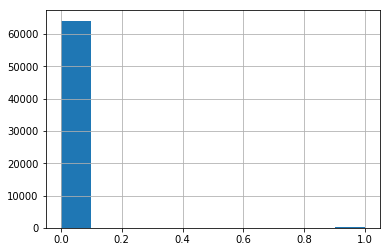

In [31]:
# Check the distribution of the target flag

df.purch.hist()

In [32]:
# % distribution of the target flag
df.purch.describe()


count    64309.000000
mean         0.002472
std          0.049662
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: purch, dtype: float64

In [35]:
# Check the correlations

df.corr()

,total_orders,purch
total_orders,1.00000,0.26219
purch,0.26219,1.00000


### Model building

In [ ]:
# Set-up

preds = 

X = 
y = 

Tri-fold partitioning is recommended as long as there's sufficient sample size avaiable. In this example, since the number of target events is very small (only 159), we will perform a two-fold paritioning of the modeling sample.

#### Two-fold partition

In [ ]:
# Split the dataframe into train(50%) and test(50%)

#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = 

len(X_train), len(X_test)

In [ ]:
# Target distribution in the trainig sample

y_train.value_counts()

In [ ]:
# Target distribution in the test sample

y_test.value_counts()

In [ ]:
#from sklearn.linear_model import LogisticRegression

# Define the model object

clf = 


# Train (fit) the model using the training sample



# Make predictions on the test sample

preds_test = 

### Model accuracy

In [ ]:
#from sklearn.metrics import accuracy_score



Why does the model appear to be very strong in spite of only two predictors that didn't look correlated with the target?

In [ ]:
# Check model's predictions against actual value of the target event



Area under the ROC surve (AUC)

In [ ]:
# Calculate the probabilities on the test sample

scores_test = 


# Calcualte AUC



## Export results

#### 1. Scored dataset (with all model attributes)

In [ ]:
scores_all = 

df['prob_to_order'] = scores_all

df.head()

In [ ]:
csv_file_zipped = out + '\olist_purch_model_scores.csv.gz'

df.to_csv(csv_file_zipped, compression='gzip')

#### 2. Export the model

In [ ]:
from sklearn.externals import joblib

model_pkl_file = out + '\olist_purch_model.joblib'



##### Load the model

In [ ]:
clf_loaded = 

clf_loaded

In [ ]:
# Use the model to score a "new" data frame

s